# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [2]:
from helper_functions import subject_df
from helper_functions import subject_df_no_feat_eng

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/helper_functions.py:23: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [3]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df = pd.read_csv('../02_analysis/df_good.csv')

# Create Target

In [4]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
df['target'] = df.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

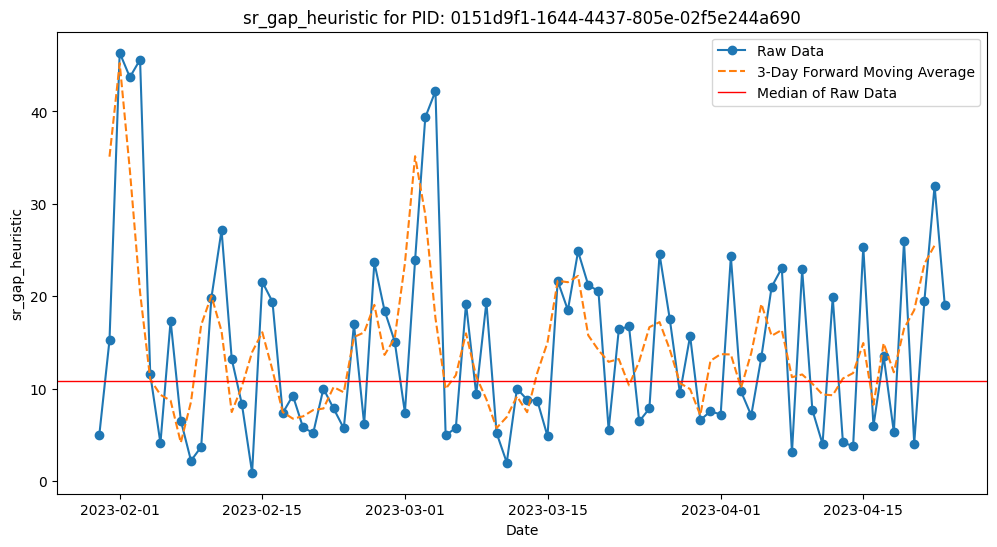

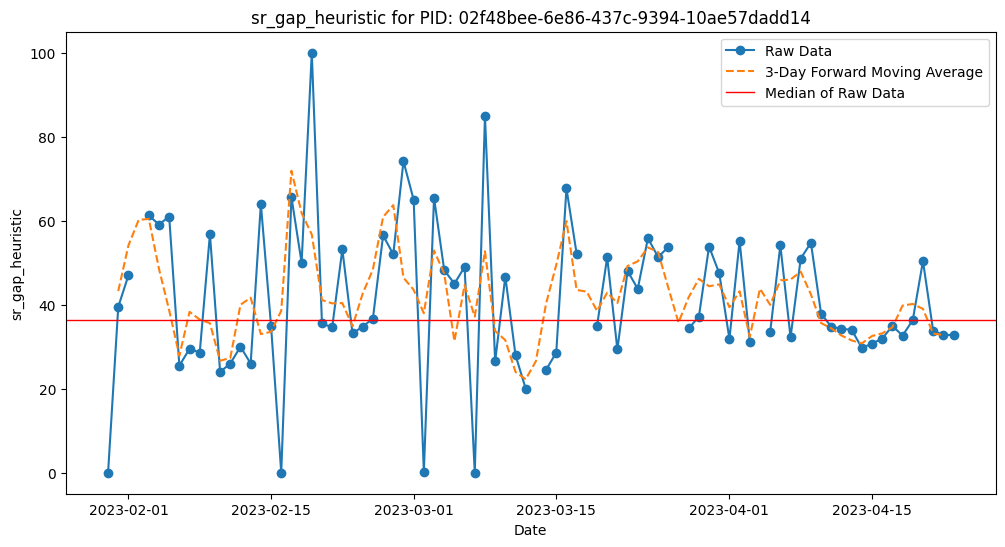

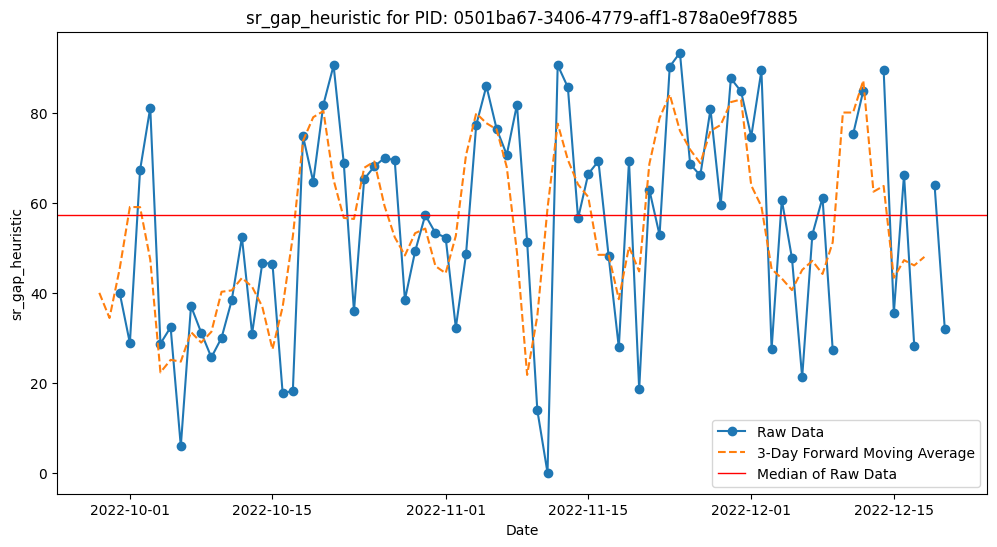

In [5]:
# Visualize a couple subjects with both original and three day smoothed gap

# This is not the same as the target as it is the average of [current day, cd+1, cd+2]
# The target column created is the average of [cd+1, cd+2, cd+3]

# Selecting two PIDs
pids = df['PID'].unique()[:3]

# Filter the dataframe for the two PIDs
df_filtered = df[df['PID'].isin(pids)][['PID', 'trial_date', 'sr_gap_heuristic']]

# Ensure the trial_date is in datetime format
df_filtered['trial_date'] = pd.to_datetime(df_filtered['trial_date'])

# Sort by trial_date for each PID
df_filtered = df_filtered.sort_values(by=['PID', 'trial_date'])

# Apply the moving average calculation for each PID
df_filtered['sr_gap_heuristic_moving_avg'] = df_filtered.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

# Plot the data for each PID
for pid in pids:
    df_pid = df_filtered[df_filtered['PID'] == pid]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic'], label='Raw Data', marker='o')
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic_moving_avg'].shift(1), label='3-Day Forward Moving Average', linestyle='--')
    
    # Add a horizontal line at the median of the raw data
    median_value = df_pid['sr_gap_heuristic'].median()
    plt.axhline(median_value, color='red', linestyle='-', linewidth=1, label='Median of Raw Data')
    
    plt.title(f'sr_gap_heuristic for PID: {pid}')
    plt.xlabel('Date')
    plt.ylabel('sr_gap_heuristic')
    plt.legend()
    plt.show()

# Model Individuals

## No Feature Engineering

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['subject', 'linear_reg', 'random_forest', 'xgboost', 'ensemble', 'ffill',
                                   'predictions_lr', 'predictions_rf', 'predictions_xgb', 'predictions_e'])

# How many features to use
num_features = 12

for i in range(len(np.unique(df.PID))):
    print("Subject", i)
    
    try:
        # No feature engineering
        df_split = subject_df_no_feat_eng(df, sub_num=i)
        
        # Separate features and target variable
        X = df_split.drop(columns=['target'])
        y = df_split['target']

        # Remove initial rows with NaN values for target
        while y.isnull().iloc[0]:
            X = X.iloc[1:].reset_index(drop=True)
            y = y.iloc[1:].reset_index(drop=True)
        
        # Count missing values before imputation
        missing_values_before = y.isnull().sum()

        # Impute missing values in the target variable using forward fill
        y = y.fillna(method='ffill')

        # Count missing values after imputation
        missing_values_after = y.isnull().sum()

        # Calculate the number of imputed values
        imputed_value_count = missing_values_before - missing_values_after

        # Ensure there are no more NaN values in y
        if y.isnull().sum() == 0:
            # Handle missing values and standardize features
            imputer = SimpleImputer(strategy='mean')
            scaler = StandardScaler()

            # Feature selection
            k_best = SelectKBest(score_func=f_regression, k=num_features)

            # Models
            lin_reg = LinearRegression()
            rf = RandomForestRegressor(n_estimators=100)
            xgb_reg = xgb.XGBRegressor(n_estimators=100)

            # TimeSeriesSplit
            tscv = TimeSeriesSplit(n_splits=5)

            # Pipelines
            lin_reg_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('regressor', lin_reg)
            ])

            rf_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('regressor', rf)
            ])

            xgb_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('regressor', xgb_reg)
            ])

            # Define the parameter grids for each model
            param_grid_lin_reg = {
                'regressor__fit_intercept': [True, False]
            }

            param_grid_rf = {
                'regressor__n_estimators': [50, 100, 200],
                'regressor__max_depth': [None, 10, 20, 30]
            }

            param_grid_xgb = {
                'regressor__n_estimators': [50, 100, 200],
                'regressor__learning_rate': [0.01, 0.1, 0.2],
                'regressor__max_depth': [3, 6, 9],
                'regressor__reg_alpha': [0, 0.1, 0.5],
                'regressor__reg_lambda': [0, 0.5, 1]
            }

            # Setup GridSearchCV for each model
            grid_lin_reg = GridSearchCV(lin_reg_pipeline, param_grid_lin_reg, cv=tscv, scoring='neg_mean_squared_error')
            grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
            grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error')

            # Fit the models
            grid_lin_reg.fit(X, y)
            grid_rf.fit(X, y)
            grid_xgb.fit(X, y)

            # Print best parameters for the XGBoost model
            print("Best parameters for XGBoost:", grid_xgb.best_params_)

            # Best estimators
            best_lin_reg = grid_lin_reg.best_estimator_
            best_rf = grid_rf.best_estimator_
            best_xgb = grid_xgb.best_estimator_

            # Ensemble with VotingRegressor
            voting_reg = VotingRegressor(estimators=[
                ('lin_reg', best_lin_reg),
                ('rf', best_rf),
                ('xgb', best_xgb)
            ])

            # Cross-validation for ensemble model
            ensemble_scores = cross_val_score(voting_reg, X, y, cv=tscv, scoring='neg_mean_squared_error')
            ensemble_rmse = np.sqrt(-ensemble_scores.mean())

            # The average performance of the best models across the cross-validation folds
            results = {
                'Linear Regression': np.sqrt(-grid_lin_reg.best_score_),
                'Random Forest': np.sqrt(-grid_rf.best_score_),
                'XGBoost': np.sqrt(-grid_xgb.best_score_),
                'Ensemble': ensemble_rmse
            }
            
            # Feature importance list
            selector = best_xgb.named_steps['k_best']
            xgb_model = best_xgb.named_steps['regressor']

            mask = selector.get_support()  # Boolean mask
            selected_indices = selector.get_support(indices=True)  # Indices of selected features
            selected_feature_names = X.columns[selected_indices]

            importances = xgb_model.feature_importances_

            feature_importances = sorted(zip(selected_feature_names, importances), key=lambda x: x[1], reverse=True)
            feature_dict = {feature: importance for feature, importance in feature_importances}

            # Make predictions using the best Linear Regression Model
            best_lin_reg.fit(X, y)
            y_pred = best_lin_reg.predict(X)
            prediction_dict_lr = [{'predicted_lr_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y)]
            
            # Make predictions using the best RF model
            best_rf.fit(X, y)
            y_pred = best_rf.predict(X)
            prediction_dict_rf = [{'predicted_rf_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y)]
            
            # Make predictions using the best XGBoost model
            best_xgb.fit(X, y)
            y_pred_ensemble = best_xgb.predict(X)
            prediction_dict_xgb = [{'predicted_xgb_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y)]
            
            # Make predictions using the best Ensemble model
            voting_reg.fit(X, y)
            y_pred = voting_reg.predict(X)
            prediction_dict_e = [{'predicted_e_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y)]

            # Save results to the DataFrame using pd.concat
            new_row = pd.DataFrame({
                'subject': [i],
                'linear_reg': [np.sqrt(-grid_lin_reg.best_score_)],
                'random_forest': [np.sqrt(-grid_rf.best_score_)],
                'xgboost': [np.sqrt(-grid_xgb.best_score_)],
                'ensemble': [ensemble_rmse],
                'ffill': [imputed_value_count],
                'feature_import_xgb': [feature_dict],
                'predictions_lr': [prediction_dict_lr],
                'predictions_rf': [prediction_dict_rf],
                'predictions_xgb': [prediction_dict_xgb],
                'predictions_e': [prediction_dict_e]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            
        else:
            print(f"Skipping subject {i} because the target variable y still contains NaN values after imputation.")
            continue
    except KeyError as err:
        print(f'Error with subject {i} in subject_df() function: {err}')


Subject 0
Best parameters for XGBoost: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 9, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 0}
Subject 1
Best parameters for XGBoost: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0.5, 'regressor__reg_lambda': 1}
Subject 2
Best parameters for XGBoost: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 9, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 1}
Subject 3
Best parameters for XGBoost: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 9, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1}
Subject 4
Best parameters for XGBoost: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 0}
Subject 5
Best parameters for XGBoost: {'regressor__learnin

KeyboardInterrupt: 

In [31]:
results_df

,subject,linear_reg,random_forest,xgboost,ensemble,ffill,predictions_lr,predictions_rf,predictions_xgb,predictions_e,feature_import_xgb
0,0,0.455026,0.165424,0.150208,0.223595,3,"[{'predicted_lr_value': 0.7812255991566073, 'a...","[{'predicted_rf_value': 0.7118668831168823, 'a...","[{'predicted_xgb_value': 0.7118668831168823, '...","[{'predicted_e_value': 0.6514564532627389, 'ac...",{'task_hanoi_movesTime_model_predict': 0.39145...
1,1,0.374994,0.273455,0.209487,0.276552,3,"[{'predicted_lr_value': 0.5099961649291598, 'a...","[{'predicted_rf_value': 0.4284519811954328, 'a...","[{'predicted_xgb_value': 0.4284519811954328, '...","[{'predicted_e_value': 0.4517182276191573, 'ac...",{'passive_sk_keyboard_sentiment_combined_posit...
2,2,0.310853,0.293036,0.280997,0.285338,3,"[{'predicted_lr_value': 0.44813862976963287, '...","[{'predicted_rf_value': 0.2868776740682272, 'a...","[{'predicted_xgb_value': 0.2868776740682272, '...","[{'predicted_e_value': 0.39142259937182056, 'a...",{'passive_sk_device_total_usage_photo_and_vide...
3,3,8.008052,0.177184,0.165987,2.695700,5,"[{'predicted_lr_value': 0.8523856790176996, 'a...","[{'predicted_rf_value': 0.7768979817528339, 'a...","[{'predicted_xgb_value': 0.7768979817528339, '...","[{'predicted_e_value': 0.7805116309909521, 'ac...",{'passive_sk_device_total_usage_games': 0.4797...
4,4,0.330285,0.272300,0.271625,0.271882,3,"[{'predicted_lr_value': 0.4947977389993203, 'a...","[{'predicted_rf_value': 0.6505165856936118, 'a...","[{'predicted_xgb_value': 0.6505165856936118, '...","[{'predicted_e_value': 0.5280820410777647, 'ac...",{'task_hanoi_movesTime_model_predict': 0.37111...
5,5,0.474119,0.241266,0.119121,0.250023,3,"[{'predicted_lr_value': 0.686504451616799, 'ac...","[{'predicted_rf_value': 0.20654717931497654, '...","[{'predicted_xgb_value': 0.20654717931497654, ...","[{'predicted_e_value': 0.5137974403057396, 'ac...","{'task_nasa_mental_demand': 0.5822395, 'passiv..."
6,6,0.338057,0.190421,0.186337,0.213115,3,"[{'predicted_lr_value': 0.5079924185606126, 'a...","[{'predicted_rf_value': 0.3673126899891803, 'a...","[{'predicted_xgb_value': 0.3673126899891803, '...","[{'predicted_e_value': 0.4307105135453586, 'ac...",{'sr_DAILY_goal1_interaction_week1': 0.3073817...
7,7,0.282070,0.229824,0.217125,0.232570,3,"[{'predicted_lr_value': 0.3572330757738096, 'a...","[{'predicted_rf_value': 0.3024697644812221, 'a...","[{'predicted_xgb_value': 0.3024697644812221, '...","[{'predicted_e_value': 0.33018176839883157, 'a...","{'affect_neg_sad_am': 0.47768012, 'task_hanoi_..."
8,8,1.517510,0.277620,0.265410,0.576848,4,"[{'predicted_lr_value': 0.4780944193268934, 'a...","[{'predicted_rf_value': 0.4599970972423801, 'a...","[{'predicted_xgb_value': 0.4599970972423801, '...","[{'predicted_e_value': 0.47984522052604345, 'a...",{'sr_DAILY_goal1_interaction_week2': 0.4456709...
9,9,0.255189,0.198507,0.181005,0.194510,3,"[{'predicted_lr_value': 0.6022206842936753, 'a...","[{'predicted_rf_value': 0.5311857526761344, 'a...","[{'predicted_xgb_value': 0.5311857526761344, '...","[{'predicted_e_value': 0.5837476415751136, 'ac...","{'task_rt_avgRT': 0.2448116, 'task_gng_avgRt':..."


In [33]:
results_df.describe()

,linear_reg,random_forest,xgboost,ensemble
count,54.000000,54.000000,54.000000,54.000000
mean,164.019209,0.248366,0.231849,54.797525
std,1198.033165,0.048287,0.044605,399.325800
min,0.216838,0.100166,0.092495,0.121463
25%,0.313264,0.216675,0.208919,0.242871
50%,0.356444,0.249035,0.231383,0.273565
75%,0.454709,0.276175,0.264760,0.314752
max,8804.679229,0.382499,0.305472,2934.883891


In [34]:
results_df.predictions_xgb[0]

[{'predicted_xgb_value': 0.7118668831168823,
  'actual_value': 0.7536525974025974},
 {'predicted_xgb_value': 0.8473944805194803, 'actual_value': 1.0},
 {'predicted_xgb_value': 0.5972463474025961,
  'actual_value': 0.7175324675324675},
 {'predicted_xgb_value': 0.430308441558441,
  'actual_value': 0.3961038961038961},
 {'predicted_xgb_value': 0.1866152597402595,
  'actual_value': 0.16680194805194806},
 {'predicted_xgb_value': 0.22238433441558478,
  'actual_value': 0.12621753246753248},
 {'predicted_xgb_value': 0.1263856456043954,
  'actual_value': 0.11079545454545453},
 {'predicted_xgb_value': 0.0669216720779221, 'actual_value': 0.0},
 {'predicted_xgb_value': 0.19403612012987018,
  'actual_value': 0.10754870129870125},
 {'predicted_xgb_value': 0.2988308566433574,
  'actual_value': 0.31006493506493504},
 {'predicted_xgb_value': 0.35186079545454596,
  'actual_value': 0.3871753246753246},
 {'predicted_xgb_value': 0.28623720029970035,
  'actual_value': 0.2938311688311688},
 {'predicted_xgb_v

In [11]:
results_df.predictions_xgb[0]

[{'predicted_xgb_value': 0.47036982, 'actual_value': 0.7536525974025974},
 {'predicted_xgb_value': 0.47036982, 'actual_value': 1.0},
 {'predicted_xgb_value': 0.47036982, 'actual_value': 0.7175324675324675},
 {'predicted_xgb_value': 0.30379257, 'actual_value': 0.3961038961038961},
 {'predicted_xgb_value': 0.21842715, 'actual_value': 0.16680194805194806},
 {'predicted_xgb_value': 0.20700242, 'actual_value': 0.12621753246753248},
 {'predicted_xgb_value': 0.20700242, 'actual_value': 0.11079545454545453},
 {'predicted_xgb_value': 0.19686878, 'actual_value': 0.0},
 {'predicted_xgb_value': 0.23482986, 'actual_value': 0.10754870129870125},
 {'predicted_xgb_value': 0.29253834, 'actual_value': 0.31006493506493504},
 {'predicted_xgb_value': 0.2793657, 'actual_value': 0.3871753246753246},
 {'predicted_xgb_value': 0.26403165, 'actual_value': 0.2938311688311688},
 {'predicted_xgb_value': 0.20700242, 'actual_value': 0.080762987012987},
 {'predicted_xgb_value': 0.20700242, 'actual_value': 0.1485389610

In [29]:
results_df.loc[0, 'feature_import_xgb']

{'task_hanoi_movesTime_model_predict': 0.39145723,
 'passive_sk_calls_outgoing': 0.38600704,
 'passive_sk_visits_home_elapsed': 0.05288751,
 'sr_DAILY_past24_socialMedia': 0.04472047,
 'task_nasa_effort': 0.03615594,
 'task_hanoi_time': 0.03579918,
 'task_food_2_rt': 0.029987877,
 'task_hanoi_moves': 0.01274949,
 'task_psat_accuracy': 0.008817821,
 'sr_DAILY_next24_occupation': 0.0014174624,
 'task_nback_missed': 0.0,
 'passive_sk_visits_work_elapsed': 0.0}

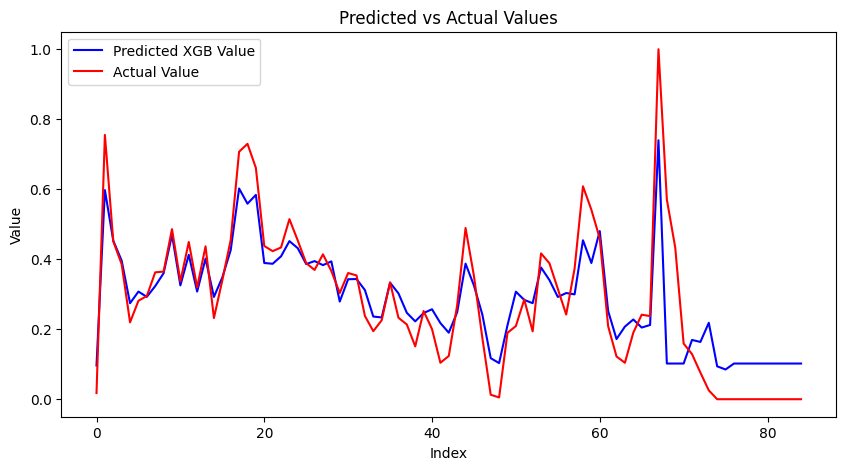

In [40]:
# Extract the predictions for the first row
predictions = results_df.loc[30, 'predictions_xgb']

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Plot the predicted and actual values
plt.figure(figsize=(10, 5))
plt.plot(predictions_df['predicted_xgb_value'], label='Predicted XGB Value', color='blue')
plt.plot(predictions_df['actual_value'], label='Actual Value', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()


In [38]:
# Save the DataFrame to a JSON file
results_df.to_json('results_df_continuous_3DayAvg_noFeatEng.json', orient='records', lines=True)

In [ ]:
# Load the DataFrame back from the JSON file
loaded_results_df = pd.read_json('results_df_continuous_3DayAvg_noFeatEng.json', orient='records', lines=True)